In [1]:
import sys
# sys.path.append('/gpfs/loomis/home.grace/ys668/software/koza4ok')
import uproot4 as uproot
import math
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve
from skTMVA import convert_bdt_sklearn_tmva

In [2]:
mltreeroot = uproot.open("mltree1.root" )
mltree = mltreeroot["Stg"]

In [3]:
Crit2 = mltree.arrays( ["Crit2_RZRatio", "Crit2_RZRatio_trackIds", 
                        "Crit2_DeltaRho", "Crit2_DeltaRho_trackIds", 
                        "Crit2_DeltaPhi", "Crit2_DeltaPhi_trackIds", 
                        "Crit2_StraightTrackRatio", "Crit2_StraightTrackRatio_trackIds"] , library="pd")
Crit3 = mltree.arrays( ["Crit3_3DAngle", "Crit3_3DAngle_trackIds", 
                        "Crit3_ChangeRZRatio", "Crit3_ChangeRZRatio_trackIds", 
                        "Crit3_2DAngle", "Crit3_2DAngle_trackIds"] , library="pd")

In [4]:
print(type(Crit2), type(Crit3))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [14]:
Crit2

Crit2_RZRatio  Crit2_RZRatio_trackIds  Crit2_DeltaRho  \
entry subentry                                                          
0     0              1.021419                      -1       -4.738697   
      1              1.022302                      -1       -4.839012   
      2              1.304533                      -1      -17.746450   
      3              1.004187                     355        1.893636   
      4              1.594602                      -1      -26.755651   
...                       ...                     ...             ...   
49499 4              1.007454                      -1        2.785313   
      5              1.299637                      -1      -15.502758   
      6              1.299396                      -1      -15.427925   
      7              1.006945                      -1        2.691032   
      8              1.006917                      -1        2.640335   

                Crit2_DeltaRho_trackIds  Crit2_DeltaPhi  \
entry subentry                                            
0     0                              -1        0.801099   
      1                              -1        0.601002   
      2                              -1       19.210548   
      3                             355        3.855710   
      4                              -1       22.318817   
...                                 ...             ...   
49499 4                              -1        0.434769   
      5                              -1       12.340158   
      6                              -1       12.452241   
      7                              -1        0.081525   
      8                              -1        0.675205   

                Crit2_DeltaPhi_trackIds  Crit2_StraightTrackRatio  \
entry subentry                                                      
0     0                              -1                  0.691984   
      1                              -1                  0.688314   
      2                              -1                  0.409136   
      3                             355                  1.068689   
      4                              -1                  0.318865   
...                                 ...                       ...   
49499 4                              -1                  0.998189   
      5                              -1                  0.688496   
      6                              -1                  0.689373   
      7                              -1                  0.996621   
      8                              -1                  0.995380   

                Crit2_StraightTrackRatio_trackIds  
entry subentry                                     
0     0                                        -1  
      1                                        -1  
      2                                        -1  
      3                                       355  
      4                                        -1  
...                                           ...  
49499 4                                        -1  
      5                                        -1  
      6                                        -1  
      7                                        -1  
      8                                        -1  

[1314613 rows x 8 columns]

In [10]:
Crit3

Crit3_3DAngle  Crit3_3DAngle_trackIds  Crit3_ChangeRZRatio  \
entry subentry                                                               
0     0              1.279950                     355             1.001022   
      1              5.687575                      -1             1.000026   
      2              5.623889                      -1             0.999895   
      3              0.006734                     364             1.000004   
      4              0.294426                      -1             0.999873   
...                       ...                     ...                  ...   
49498 2              0.185218                      21             1.000437   
49499 0              0.035954                       9             0.999926   
      1              1.053257                      -1             0.999591   
      2              0.133228                      -1             1.000170   
      3              2.018154                      -1             1.000533   

                Crit3_ChangeRZRatio_trackIds  Crit3_2DAngle  \
entry subentry                                                
0     0                                  355      12.743137   
      1                                   -1      35.945984   
      2                                   -1      30.794954   
      3                                  364       0.100589   
      4                                   -1       5.050444   
...                                      ...            ...   
49498 2                                   21       0.643643   
49499 0                                    9       0.037294   
      1                                   -1       8.654246   
      2                                   -1       0.889553   
      3                                   -1      16.856396   

                Crit3_2DAngle_trackIds  
entry subentry                          
0     0                            355  
      1                             -1  
      2                             -1  
      3                            364  
      4                             -1  
...                                ...  
49498 2                             21  
49499 0                              9  
      1                             -1  
      2                             -1  
      3                             -1  

[1118529 rows x 6 columns]

In [97]:
hit2_obs = {}
hit2_obs['true'] = Crit2[['Crit2_RZRatio', 'Crit2_DeltaRho', 'Crit2_DeltaPhi', 'Crit2_StraightTrackRatio']][Crit2.Crit2_DeltaPhi_trackIds != -1]
hit2_obs['false'] = Crit2[['Crit2_RZRatio', 'Crit2_DeltaRho', 'Crit2_DeltaPhi', 'Crit2_StraightTrackRatio']][Crit2.Crit2_DeltaPhi_trackIds == -1]

In [99]:
hit2_obs['false'] = hit2_obs['false'][0:275505]

In [100]:
hit3_obs = {}
hit3_obs['true'] = Crit3[['Crit3_3DAngle', 'Crit3_ChangeRZRatio', 'Crit3_2DAngle']][Crit3.Crit3_3DAngle_trackIds != -1]
hit3_obs['false'] = Crit3[['Crit3_3DAngle', 'Crit3_ChangeRZRatio', 'Crit3_2DAngle']][Crit3.Crit3_3DAngle_trackIds == -1]

In [101]:
print (type(hit3_obs), type(hit3_obs['true']))

<class 'dict'> <class 'pandas.core.frame.DataFrame'>


In [102]:
X2 = np.concatenate((hit2_obs['true'], hit2_obs['false']))
y2 = np.concatenate((np.ones(hit2_obs['true'].shape[0]),
                    np.zeros(hit2_obs['false'].shape[0])))
X3 = np.concatenate((hit3_obs['true'], hit3_obs['false']))
y3 = np.concatenate((np.ones(hit3_obs['true'].shape[0]),
                    np.zeros(hit3_obs['false'].shape[0])))

Train & test with crit2

In [103]:
# The Training and Testing Split, https://betatim.github.io/posts/sklearn-for-TMVA-users/
X2_dev,X2_eval, y2_dev,y2_eval = train_test_split(X2, y2,
                                              test_size=0.33, random_state=42)
X2_train,X2_test, y2_train,y2_test = train_test_split(X2_dev, y2_dev,
                                                  test_size=0.33, random_state=492)

In [133]:
# Training Decision Trees
dt = DecisionTreeClassifier(max_depth=5)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME.R',
                         n_estimators=500,
                         learning_rate=0.25)

bdt.fit(X2_train, y2_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.25, n_estimators=500)

In [134]:
# Assessing a Classifier's Performance
y2_predicted = bdt.predict(X2_test)
print (classification_report(y2_test, y2_predicted,
                            target_names=["fake", "real"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y2_test,
                                                  bdt.decision_function(X2_test))))

              precision    recall  f1-score   support

        fake       0.86      0.84      0.85     60914
        real       0.84      0.87      0.85     60915

    accuracy                           0.85    121829
   macro avg       0.85      0.85      0.85    121829
weighted avg       0.85      0.85      0.85    121829

Area under ROC curve: 0.9179


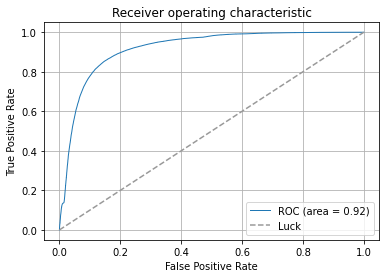

In [135]:
# Compute ROC curve and area under the curve
decisions = bdt.decision_function(X2_test)
fpr, tpr, thresholds = roc_curve(y2_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

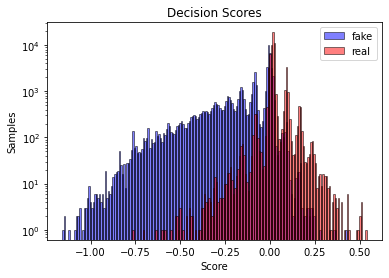

In [136]:
# Plot the two-class decision scores, https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
plot_colors = "br"
plot_step = 0.02
class_names = 'fake','real'

plot_range = (decisions.min(), decisions.max())
# plot_range = (-1, 0.25)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(decisions[y2_test == i],
             bins=200,
             range=plot_range,
             facecolor=c,
             label=n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
# plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')
plt.yscale('log')

plt.show()

<ipython-input-108-22f38b10fec6>:19: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram(decisions[2],
<ipython-input-108-22f38b10fec6>:28: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram(decisions[3],


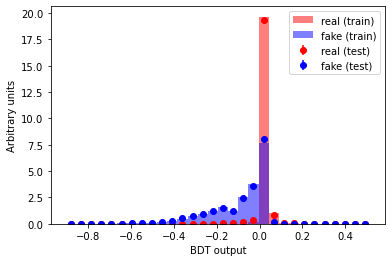

In [108]:
# Overtraining Check, https://betatim.github.io/posts/sklearn-for-TMVA-users/
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0], color='r', alpha=0.5, range=low_high, bins=bins,histtype='stepfilled', density=True,
             label='real (train)')
    plt.hist(decisions[1], color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='fake (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='real (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, normed=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='fake (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X2_train, y2_train, X2_test, y2_test)

In [125]:
#skTMVA converter, https://github.com/yuraic/koza4ok
convert_bdt_sklearn_tmva(bdt, [('Crit2_RZRatio', 'F'), ('Crit2_DeltaRho', 'F'), ('Crit2_DeltaPhi', 'F'), ('Crit2_StraightTrackRatio', 'F')], 'crit2.xml')

Train and test with crit3

In [127]:
X3_dev,X3_eval, y3_dev,y3_eval = train_test_split(X3, y3,
                                              test_size=0.33, random_state=42)
X3_train,X3_test, y3_train,y3_test = train_test_split(X3_dev, y3_dev,
                                                  test_size=0.33, random_state=492)

In [128]:
dt = DecisionTreeClassifier(max_depth=5)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME.R',
                         n_estimators=100,
                         learning_rate=0.75)

bdt.fit(X3_train, y3_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.75, n_estimators=100)

In [129]:
y3_predicted = bdt.predict(X3_test)
print (classification_report(y3_test, y3_predicted,
                            target_names=["fake", "real"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y3_test,
                                                  bdt.decision_function(X3_test))))

              precision    recall  f1-score   support

        fake       0.97      0.97      0.97    214600
        real       0.83      0.79      0.81     32707

    accuracy                           0.95    247307
   macro avg       0.90      0.88      0.89    247307
weighted avg       0.95      0.95      0.95    247307

Area under ROC curve: 0.9676


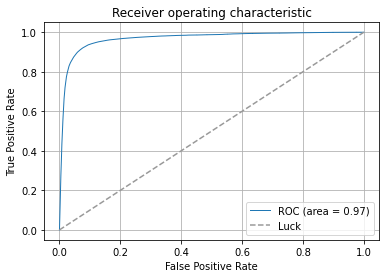

In [130]:
decisions = bdt.decision_function(X3_test)
fpr, tpr, thresholds = roc_curve(y3_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

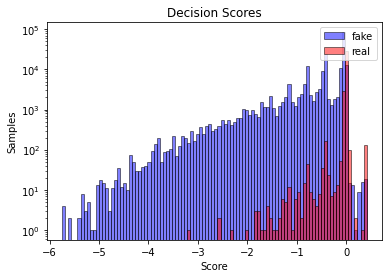

In [131]:
plot_colors = "br"

class_names = 'fake','real'

plot_range = (decisions.min(), decisions.max())
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(decisions[y3_test == i],
             bins=100,
             range=plot_range,
             facecolor=c,
             label=n,
             alpha=.5,
             edgecolor='k')

plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')
plt.yscale('log')

plt.show()

In [132]:
convert_bdt_sklearn_tmva(bdt, [('Crit3_3DAngle', 'F'), ('Crit3_ChangeRZRatio', 'F'), ('Crit3_2DAngle', 'F')], 'crit3.xml')

In [6]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import os

In [7]:
Crit2 = mltree.arrays( ["Crit2_RZRatio", "Crit2_RZRatio_trackIds", 
                        "Crit2_DeltaRho", "Crit2_DeltaRho_trackIds", 
                        "Crit2_DeltaPhi", "Crit2_DeltaPhi_trackIds", 
                        "Crit2_StraightTrackRatio", "Crit2_StraightTrackRatio_trackIds"] , library="pd")


In [8]:
hit2_obs = {}
hit2_obs['true'] = Crit2[['Crit2_RZRatio', 'Crit2_DeltaRho', 'Crit2_DeltaPhi', 'Crit2_StraightTrackRatio']][Crit2.Crit2_DeltaPhi_trackIds != -1]
hit2_obs['false'] = Crit2[['Crit2_RZRatio', 'Crit2_DeltaRho', 'Crit2_DeltaPhi', 'Crit2_StraightTrackRatio']][Crit2.Crit2_DeltaPhi_trackIds == -1]

In [9]:
X2 = np.concatenate((hit2_obs['true'], hit2_obs['false']))
Y2 = np.concatenate((np.ones(hit2_obs['true'].shape[0]),
                    np.zeros(hit2_obs['false'].shape[0])))

In [10]:
train_X2, eval_X2, train_Y2, eval_Y2 = train_test_split(X2, Y2,
                                              test_size=0.33, random_state=43)

In [24]:
def build_model() :
    model = Sequential()
    model.add(Dense(8, input_dim=4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [25]:
# Get the model built in the function above
model = build_model()
# compile the model and set the loss function, optimizer and metrics to check during training.
model.compile(loss='huber_loss', optimizer='adam', metrics=['mse','mae'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [26]:
%%time
history = model.fit(train_X2, train_Y2, epochs=1000, batch_size=5000,  verbose=0, validation_split=0.5)

CPU times: user 5min 13s, sys: 46.8 s, total: 6min
Wall time: 2min 53s


In [27]:
import matplotlib.pyplot as plt
fs = ( 16, 9 ) # lets make all our figures 16 by 9

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


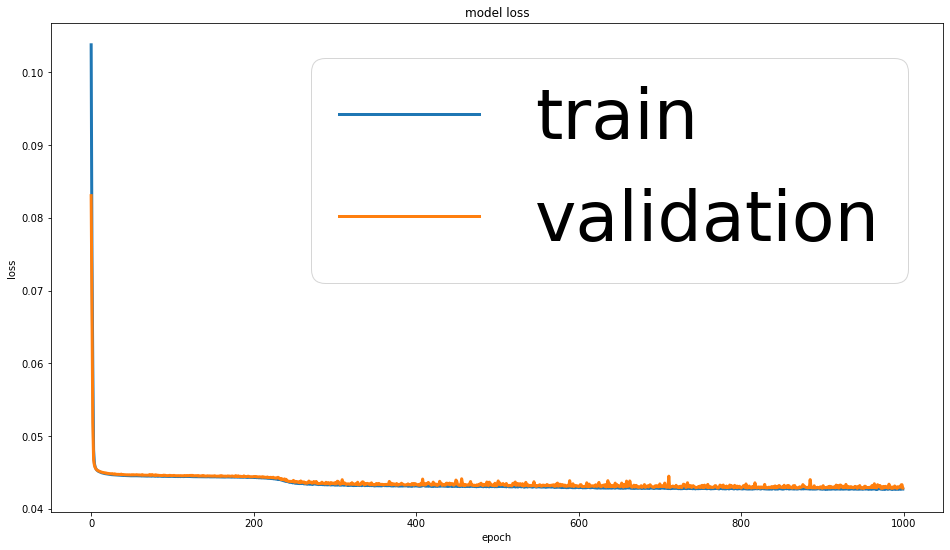

In [28]:
plt.figure(figsize=fs)
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'], linewidth=3)
plt.plot(history.history['val_loss'], linewidth=3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right', prop={'size': 70})
# plt.gca().set_ylim((0, 1))
# plt.semilogx()
plt.show()

In [29]:
N = 400000
pred_Y = np.array(model.predict(eval_X2[:N]))

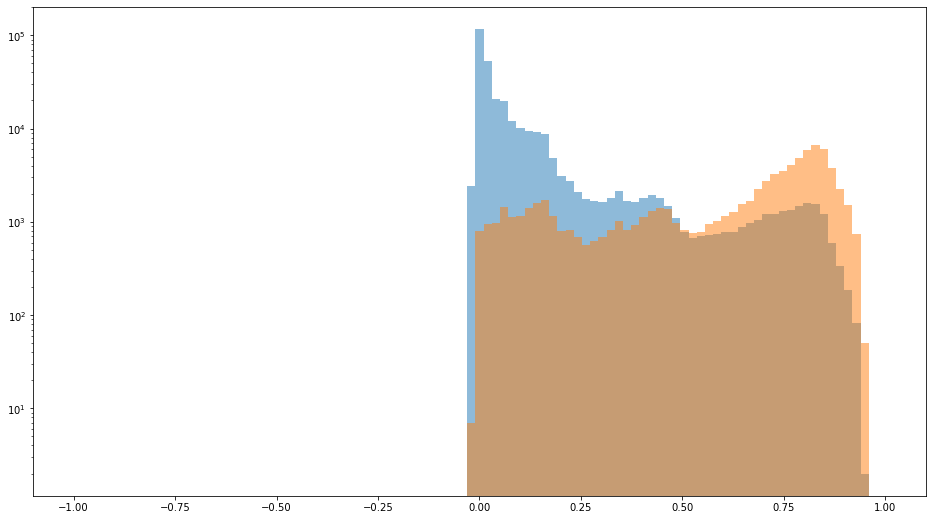

In [30]:
plt.figure(figsize=fs)
plt.hist( [ y0[0] for y0, y1 in zip(pred_Y[:N], eval_Y2[:N]) if y1 == 0 ], bins=np.linspace( -1.00, 1.0, 100 ), alpha=0.5 )
plt.hist( [ y0[0] for y0, y1 in zip(pred_Y[:N], eval_Y2[:N]) if y1 == 1 ], bins=np.linspace( -1.0, 1.0, 100 ), alpha=0.5 )
plt.semilogy()
plt.show()

In [31]:
bg = [ y0[0] for y0, y1 in zip(pred_Y[:N], eval_Y2[:N]) if y1 == 0 ]
sig = [ y0[0] for y0, y1 in zip(pred_Y[:N], eval_Y2[:N]) if y1 == 1 ]

In [32]:
cut = 0.2
bgeff = (np.array(bg) > cut).sum() / (np.array(bg) > -0.5).sum()
eff = (np.array(sig) > cut).sum() / (np.array(sig) > -0.5).sum()

print( "purity=", 1-bgeff)
print( "eff=", eff)

purity= 0.8506478515112319
eff= 0.8495602677772341


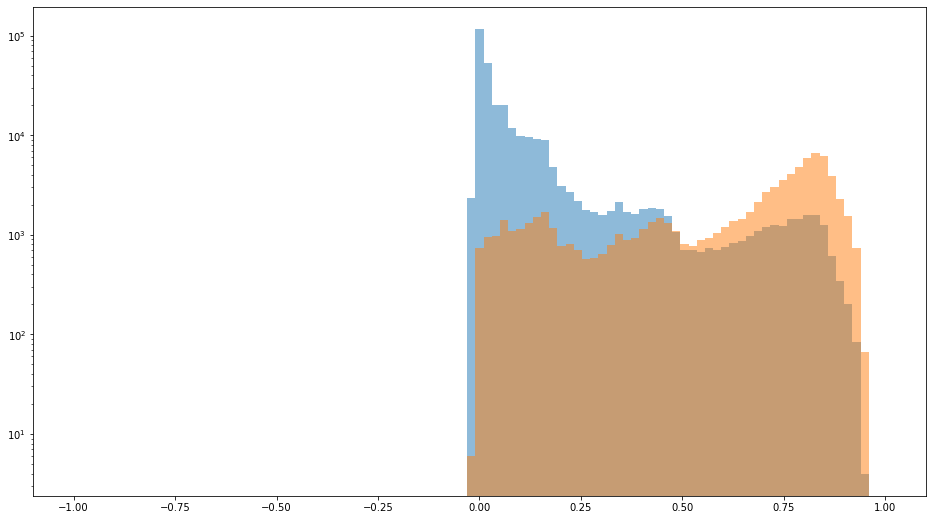

In [33]:
N = 400000
pred_Y = np.array(model.predict(train_X2[:N]))
plt.figure(figsize=fs)
plt.hist( [ y0[0] for y0, y1 in zip(pred_Y[:N], train_Y2[:N]) if y1 == 0 ], bins=np.linspace( -1.00, 1.0, 100 ), alpha=0.5 )
plt.hist( [ y0[0] for y0, y1 in zip(pred_Y[:N], train_Y2[:N]) if y1 == 1 ], bins=np.linspace( -1.0, 1.0, 100 ), alpha=0.5 )
plt.semilogy()
plt.show()